# Preprocessing to improve accuracy (Boston dataset revisited)

<div style="text-align: right;">
    <a href="Preprocessing.ipynb">このページのオリジナルのipynbファイル</a>
    <a href="index.html">トップページへ</a>
</div>


機械学習による回帰分析の精度向上のために使われるいくつかの方法を試してみる。

用いるサンプルデータセットはBostonである。


## Standardization

<a href="multiple_regression.html#scatter_matrix_boston">線形重回帰の節"</a>でみたように、説明変数の値域に大きなばらつきがある場合は、それを揃えてから、回帰分析を行うのがよい。特に線形回帰やニューラルネットの場合はそうである。

説明変数をスケールして、平均値をゼロ、標準偏差を１に揃えることを標準化(standardization)と呼び、scikit-learnにはそれを行うStandardScalerが用意されている。


### BostonデータのDataFrameへの読み込みと標準化

sckit-learnのバージョン1.2からはbostonデータが削除されたので、データのラベルを削除した代替物をCMUのサイトから直接入手する。

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

# データの読み込み
# 新しいsklearnではbostonデータは廃止に
# boston = datasets.load_boston()
# features = pd.DataFrame(boston.data, columns=boston.feature_names)
# targets = boston.target
# features

# 代替データ
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
features = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
targets = raw_df.values[1::2, 2]

### 精度検証の方法

正規化(sdandization)の効果をみるために、全データのうち8割（可変）を機械の訓練(training)データに、残りの2割を予測精度確認のためのテストデータに分け、前者で訓練した機械を使って、後者の説明変数の値を代入して予測値を計算し、観測値と比較する。

よく用いられるのは決定係数(R2スコア)である。

決定係数のWikipediaページ https://ja.wikipedia.org/wiki/%E6%B1%BA%E5%AE%9A%E4%BF%82%E6%95%B0


訓練データの抽出（分割）はランダムに行う。 (train_test_splitの利用)

In [16]:
# 訓練データとテストデータへの分割 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, random_state=42)

# データの正規化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train) #正規化
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
# fit_transform may be useful. It scales data and then transform them to ndarray. "fit" returns an object. 
X_train_scaled


0         1         2         3         4         5         6   \
0    1.287702 -0.500320  1.033237 -0.278089  0.489252 -1.428069  1.028015   
1   -0.336384 -0.500320 -0.413160 -0.278089 -0.157233 -0.680087 -0.431199   
2   -0.403253  1.013271 -0.715218 -0.278089 -1.008723 -0.402063 -1.618599   
3    0.388230 -0.500320  1.033237 -0.278089  0.489252 -0.300450  0.591681   
4   -0.325282 -0.500320 -0.413160 -0.278089 -0.157233 -0.831094  0.033747   
..        ...       ...       ...       ...       ...       ...       ...   
399 -0.387850 -0.500320 -0.352167 -0.278089 -0.310348 -0.677264  0.834884   
400 -0.373414  0.364589 -0.584520 -0.278089 -0.786706 -0.649038 -0.946216   
401 -0.405470  2.959318 -1.303361 -0.278089 -1.033391  0.450354 -1.389703   
402  0.851897 -0.500320  1.033237 -0.278089  1.561057  0.441886  0.931450   
403 -0.381356 -0.500320 -0.352167 -0.278089 -0.310348  0.125758  0.602411   

           7         8         9         10        11        12  
0   -0.802173  1.706891  1.578434  0.845343 -0.074337  1.753505  
1    0.324349 -0.624360 -0.584648  1.204741  0.430184 -0.561474  
2    1.330697 -0.974048 -0.602724 -0.637176  0.065297 -0.651595  
3   -0.839240  1.706891  1.578434  0.845343 -3.868193  1.525387  
4   -0.005494 -0.624360 -0.584648  1.204741  0.379119 -0.165787  
..        ...       ...       ...       ...       ...       ...  
399 -0.750355 -0.507797 -0.120700  1.159817  0.430731  0.873419  
400  0.291651 -0.740922 -1.090773  0.126546  0.353970  0.076412  
401  2.130899 -0.624360 -0.747331 -0.592251  0.379010 -0.910692  
402 -0.790898  1.706891  1.578434  0.845343 -2.694586  1.522570  
403 -0.513719 -0.507797 -0.120700  1.159817 -3.121581 -0.257316  

[404 rows x 13 columns]

### モデルの選択

線形回帰とランダムフォレストを使ってパフォーマンスを検証する。

- Linear Regression
- Random Forest


In [17]:
# モデルの選択

model = [] # モデルをリストとして記憶

# (1) 重回帰
from sklearn.linear_model import LinearRegression
model.append({"model": LinearRegression(), "name": "Linear Regression"})

# (2)ランダムフォレスト回帰
from sklearn.ensemble import RandomForestRegressor
model.append({"model": RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0),
              "name": "Random Forest Regressor"})


### 学習と評価

scikit-learnにおける評価指標算出関数については、次のURLを参照してほしい。

https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

In [18]:
# 予測と評価
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

result = []
X = X_train_scaled
X_t = X_test_scaled

for mlm in model:
    # 学習
    mlm['model'].fit(X, y_train)
    predicted_test = mlm['model'].predict(X_t)
    result.append({"predictedVal": predicted_test, "observedVal": y_test,
                  "name": mlm['name']}) # To use later
    test_score = r2_score(y_test, predicted_test)
    spearman = spearmanr(y_test, predicted_test)
    pearson = pearsonr(y_test, predicted_test)
    print(mlm['name'])
    # print(f'Out-of-bag R-2 score estimate: {model.oob_score_:>5.3}') $ only for random forest
    print(f'R-2 score: {test_score:>5.3}')
    print(f'Spearman correlation: {spearman[0]:.3}')
    print(f'Pearson correlation: {pearson[0]:.3}')

Linear Regression
R-2 score: 0.669
Spearman correlation: 0.855
Pearson correlation: 0.827
Random Forest Regressor
R-2 score: 0.883
Spearman correlation: 0.903
Pearson correlation: 0.94


### 推定値と実測値の比較 (散布図)



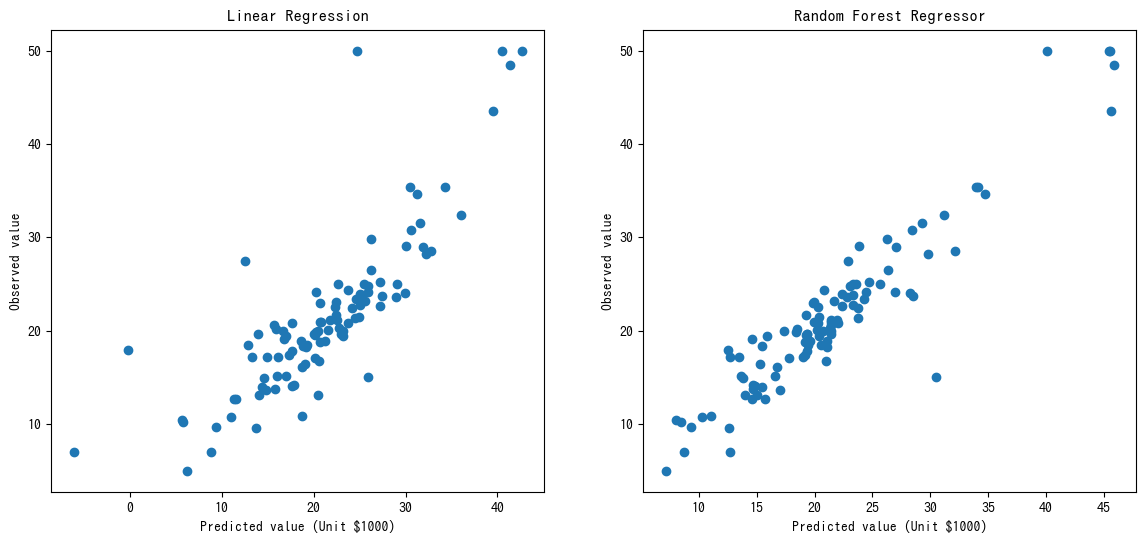

In [19]:
%matplotlib inline
# 予測と観測値の散布図
num_fig = len(result)
fig = plt.figure(figsize=(14,6))
for i in range(num_fig):
    ax1 = fig.add_subplot(1,num_fig, i+1)
    ax1.scatter(result[i]['predictedVal'], result[i]['observedVal'])
    ax1.set_xlabel("Predicted value (Unit $1000)")
    ax1.set_ylabel("Observed value")
    ax1.set_title(result[i]['name'])
plt.show()

## 説明変数の削減 - 主成分分析 (Principal Component Analysis: PCA)

多数の説明変数(特徴量)がある場合、回帰分析を行う前処理として、目的変数とは関係ないものを削除を行うことがある。

代表例として、主成分分析がある。

特徴量の線形結合から、もっとも目的変数を説明できるものを選ぶ。比較的少数の量（線形結合）が見つかれば、それを説明変数として回帰分析を行う。

多数のWebコンテンツがあるので、それらを参照してほしい。

例：

https://inoccu.com/docs/datascience/pca.html


In [20]:
# データの正規化
from sklearn.preprocessing import StandardScaler
scaledFeatures = StandardScaler().fit_transform(features)

# PCA
import sklearn.decomposition as dec
pca = dec.PCA()
#pca.fit(scaledFeatures)
x_pc = pca.fit_transform(scaledFeatures)

In [21]:
label = ["CRIM: 人口 1 人当たりの犯罪発生数",
         "ZN: 25,000平方フィート以上の住居区画の占める割合",
         "INDUS: 小売業以外の商業が占める面積の割合",
         "CHAS: チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外)",
         "NOX: NOx の濃度","RM: 住居の平均部屋数",
         "AGE: 1940 年より前に建てられた物件の割合",
         "DIS: 5 つのボストン市の雇用施設からの距離 (重み付け済)",
         "RAD: 環状高速道路へのアクセスしやすさ",
         "TAX: $10,000 ドルあたりの不動産税率の総計",
         "PTRATIO: 町毎の児童と教師の比率",
         "B: 町毎の黒人 (Bk) の比率を次の式で表したもの。 1000(Bk – 0.63)2",
         "LSTA: 給与の低い職業に従事する人口の割合 (%)]"]

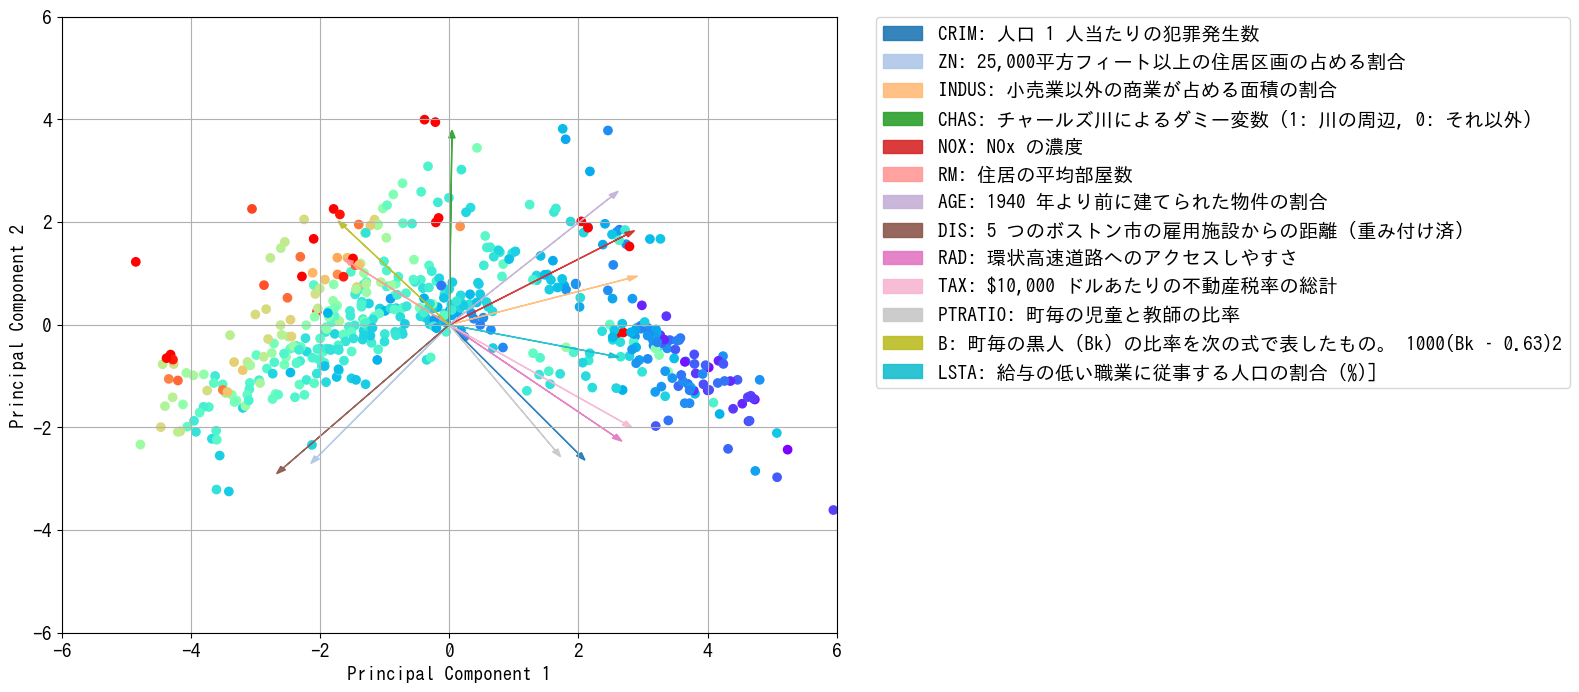

In [24]:
plt.rcParams['font.family'] = 'IPAGothic' # Linux上で日本語フォントを扱う場合
# plt.rcParams['font.family'] = 'MS Gothic' # Windowsで日本語フォントが使えないとき利用

# color map
import matplotlib.cm as cm
cm4arrow = plt.get_cmap("tab20")

### plot
x_data = x_pc[:,0]
y_data = x_pc[:,1]
pc0 = pca.components_[0]
pc1 = pca.components_[1]
plt.figure(figsize=(10,8))
plt.scatter(x_data, y_data, c = targets/len(targets), cmap=cm.rainbow)
for i in range(pc0.shape[0]):
    plt.arrow(0, 0, pc0[i]*8, pc1[i]*8, color=cm4arrow(i/len(label)), width=0.0005, head_width=0.1, alpha=0.9, label=label[i])
    # plt.text(pc0[i]*9, pc1[i]*9, features.columns.values[i], color=cm4arrow(i/len(label)), fontsize=12)
plt.xlim([-6,6])
plt.ylim([-6,6])
plt.xlabel('Principal Component 1', fontsize = 14)
plt.ylabel('Principal Component 2', fontsize = 14)
plt.tick_params(labelsize = 14)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.show()

- 第一主成分には、NOX,TAX, RAD, INDAS, CRIMなどが正の側に、DIS、ZNが負の側に大きく寄与しており、住居地としては不利な要素が表れている。
- 第２主成分は、CHAS, RMなどが正の方向に、CRIM, DIS, PTRATIOなどが負の方向に寄与しており、良い居住環境を表す。

点は、目的変数(target)である住宅価格を青から赤の rainbow color で表してある。高価格(赤色系）が左上に、安価なものが点は右下に分布していることと一致するが、それほど明確とは言えない。

第3成分をいれて3次元空間上でみたらどうだろうか？試してみよう。

(notebookの中でプロットを視点を変えるなどをインタラクティブに行うには、"%matplotlib nbagg"にするのがコツである。)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

# Figureを追加
fig = plt.figure(figsize = (7, 7))

# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# Axesのタイトルを設定
ax.set_title("PCA for Boston Data", size = 20)

# 軸ラベルを設定
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

x_data = x_pc[:,0]
y_data = x_pc[:,1]
z_data = x_pc[:,2]
ax.scatter(x_data, y_data, z_data, c = targets/len(targets), cmap=cm.rainbow)
plt.show()

一般に、説明変数の組み合わせ（線形結合）の一部を明確に抜き出すことができれば、回帰分析を行う際の前処理として変数削減を行うことができる。

例えば、Bostonデータの13個の説明変数から、学習によって13個の変数の線形結合によって見つけた３つ変数だけによる予測を行う方法をとれば計算時間を短くできる。

各項目の第1主成分の比率は次のようである。

In [35]:
pca.components_[0]

array([ 0.2509514 , -0.25631454,  0.34667207,  0.00504243,  0.34285231,
       -0.18924257,  0.3136706 , -0.32154387,  0.31979277,  0.33846915,
        0.20494226, -0.20297261,  0.30975984])

### Kernel PCA

PCAは、分類問題に適用されることもある。

下の例は、線形結合ではなく、カーネル法を用いたPCAの例である。線形結合ではないので、主成分が何を表すかはわからなくなるが、分類機として利用する場合は、これの方が有用な場合があるだろう。ここで扱ったBostonの例では、分類機としてKernelPCAのほうがよいとは言えない（と思う）。

この場合は、住宅価格も１変数として加えて分析にかけるのが望ましいかもしれない。

In [14]:
dec_pca = dec.KernelPCA(kernel="rbf")
dec_pca_result = dec_pca.fit_transform(scaledFeatures)

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(dec_pca_result[:, 0], dec_pca_result[:, 1], c= targets/len(targets),
           s=30, cmap=plt.cm.rainbow)
ax.set_xlabel('Principal Component 1', fontsize = 14)
ax.set_ylabel('Principal Component 2', fontsize = 14)
plt.tick_params(labelsize = 14)

<IPython.core.display.Javascript object>

## Optimizing hyper-parameters

それぞれのモデルのhyper-parametersは、利用者が与える必要があるが、数値的に試してみて、もっとも決定係数が良いものを選ぶこともよく行われる。

scikit-learnに含まれるモジュールの解説は、次のURLにある。

https://scikit-learn.org/stable/model_selection.html

もっとも頻繁に用いられているのは、パラメータ範囲をすべて調べ上げる方法でGrid-Searchと呼ばれる。(SVCのプログラム例で、使ってみているので参照してほしい。https://toyoki-lab.ee.yamanashi.ac.jp/~toyoki/lectures/PracDataSci/svc_svm_in_scikit-learn.html#svc_with_kernel



## Evaluating model performance

モデルの妥当性の検証には、交差検定が用いられる。与えられたデータセットをトレーニングデータとテストデータに分け、トレーニングされたマシーンの予測精度をテストデータを使って検証することは、以前の節で行ってみた。

その選び方によって、たまたま良い結果が得られたり、その逆であったりすることがあるため、データの分割を繰り返し、検証することを交差検定(cross-validation)とよぶ。https://scikit-learn.org/stable/model_selection.html の解説及びプログラム例を参照してほしい。

モデルの選択だけではなく、モデルのパラメータ（SVMでのカーネルの選択や、ニューラルネットのレイヤやノード数など）の設定を交差検定で決めることはよく行われる。

